In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import prod

In [2]:
sns.set_theme(style="white")

In [3]:
dims = 20,20
halo = (2,2),(2,2)
prob = '2d5pt'
dtype = np.float32
nodes = 2
mpi = True

In [4]:
devito = np.fromfile(f"{prob}.devito.data", dtype).reshape(dims)
orig = np.fromfile(f"{prob}.input.data", dtype).reshape([(x + h[0] + h[1]) for x, h in zip(dims, halo)])

if mpi:
    # load data and re-order
    stencil_raw = np.fromfile(f"{prob}.stencil.data", dtype)[0:prod(dims)]
    stencil = np.zeros(dims)
    local_dims = dims[0], dims[1] // nodes
    for i in range(nodes):
        local = stencil_raw[(i * prod(local_dims)):((i+1) * prod(local_dims))].reshape(local_dims)
        stencil[:,(i * local_dims[1]):((i+1) * local_dims[1])] = local
else:
    stencil = np.fromfile(f"{prob}.stencil.data", dtype).reshape([(x + h[0] + h[1]) for x, h in zip(dims, halo)])


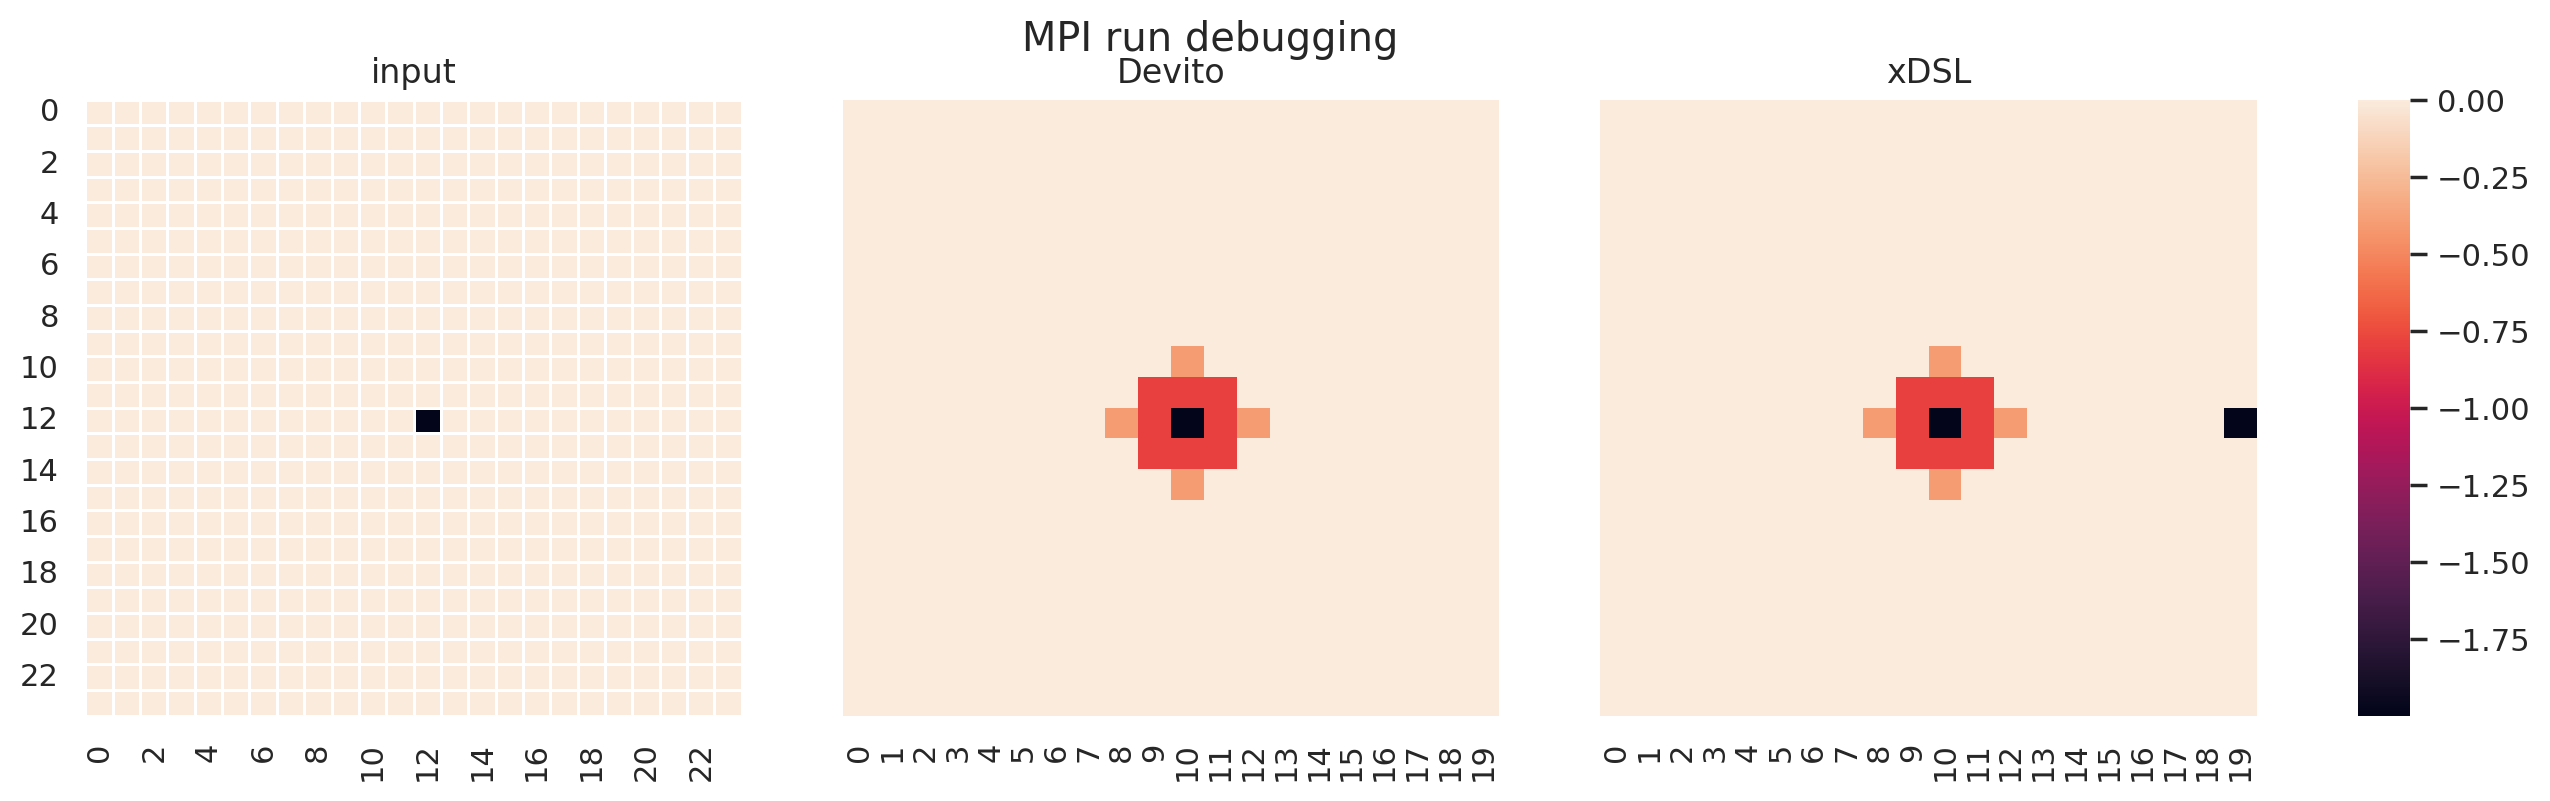

In [5]:
f,(ax1,ax2,ax3, cbar_ax) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize=(15, 4), dpi=200)
ax1.get_shared_y_axes().join(ax2,ax3)

m, M = min(devito.min(), stencil.min()), max(devito.max(), stencil.max())

titles = iter(['input', 'Devito', 'xDSL'])

kwargs = dict(vmin=m, vmax=M) # lineweight=0.5

for g, yticks in ((sns.heatmap(orig, linewidth=0.5, ax=ax1, cbar=False), True),
          (sns.heatmap(devito,**kwargs, ax=ax2, cbar=False), False),
          (sns.heatmap(stencil, **kwargs, ax=ax3, cbar_ax=cbar_ax), False)):
    g.set_ylabel('')
    g.set_xlabel('')
    g.set(title=next(titles))
    if not yticks:
        g.set_yticks([])
    tl = g.get_xticklabels()
    g.set_xticklabels(tl, rotation=90)
    tly = g.get_yticklabels()
    g.set_yticklabels(tly, rotation=0)
f.suptitle('MPI run debugging')
plt.show()

In [6]:
np.linalg.norm(devito) - np.linalg.norm(stencil)

-0.585349662382546

In [7]:
raw = np.fromfile(f"{prob}.stencil.data", dtype)[0:prod(dims)]

In [8]:

r0 = raw[:prod(dims)//2].reshape((20,10))
r1 = raw[prod(dims)//2:].reshape((20,10))

new_data = np.zeros((20,20))
new_data[:,:10] = r0
new_data[:,10:] = r1

<AxesSubplot:>

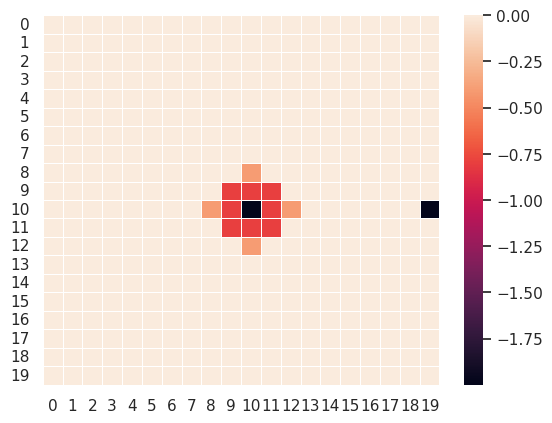

In [9]:
sns.heatmap(new_data, linewidth=0.5)

[Text(0.5, 1.0, 'raw output')]

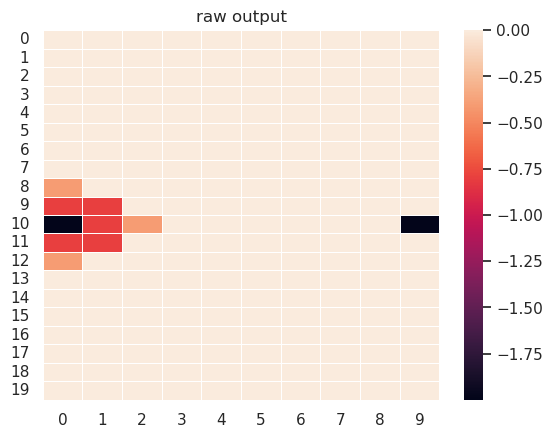

In [10]:
g=sns.heatmap(np.fromfile(f"{prob}.stencil.data", dtype)[200:400].reshape((20,10)), linewidths=.5)
g.set(title='raw output')

In [11]:
orig[...,0:orig.shape[0]//2] = 1
orig[...,orig.shape[0]//2:] = 2
orig.tofile('2d5pt.input.data-split')

In [12]:
for index, values in np.ndenumerate(orig):
    orig[index] = index[0] * 100 + index[1]
    
orig.tofile('2d5pt.input.data-split')

<AxesSubplot:>

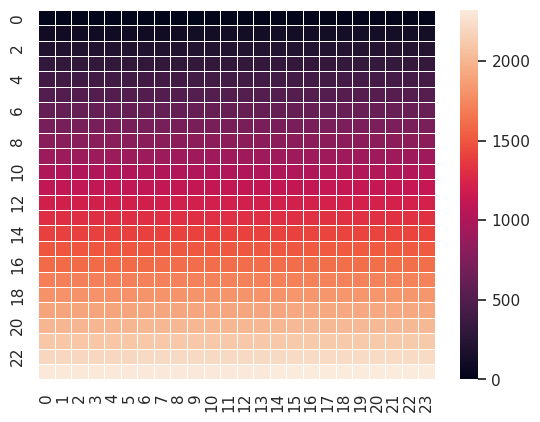

In [13]:
sns.heatmap(orig, linewidths=.5)

In [14]:
r0 = np.fromfile('2d5pt.stencil.data.rank0', dtype).reshape((24,24))
r1 = np.fromfile('2d5pt.stencil.data.rank1', dtype).reshape((24,24))

<AxesSubplot:>

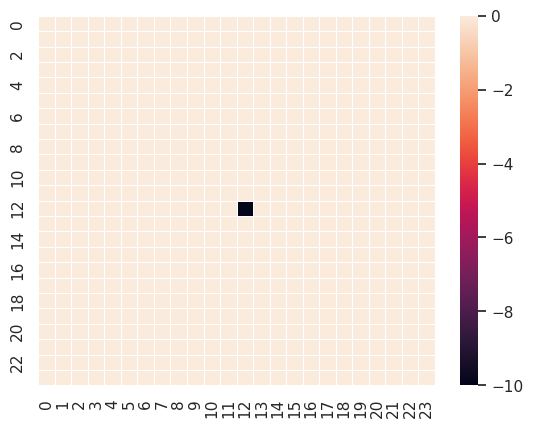

In [15]:
sns.heatmap(r0, linewidths=.5)

<AxesSubplot:>

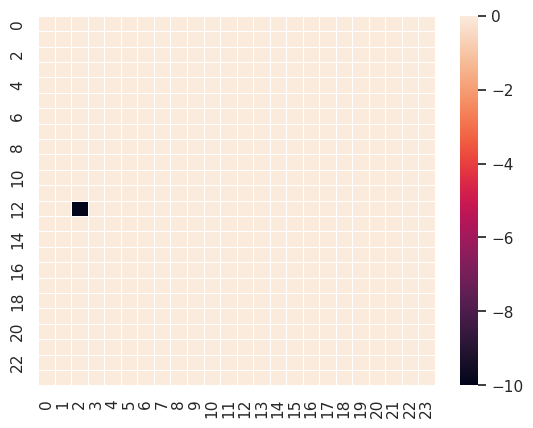

In [16]:
sns.heatmap(r1, linewidths=.5)

In [17]:
#r1_orig = r1.copy()
r1 = r1_orig

NameError: name 'r1_orig' is not defined

In [ ]:
r1[2,2] = r1[2,12] = np.nan
sns.heatmap(r1, linewidths=.5)